# **A 7-taps re-programmable Finite Impulse Response filter on FPGA**
## **analysis** of the implemented FIR

#### project for MAPD module A - A.Y. 2021/22, University of Padua

*Barone Francesco Pio*

In [1]:
# general imports
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

In [2]:
# general properties of the FIR filter
sampling_frequency = 200   #  [Hz] frequency of the sampled signals 
taps = 7                   # number of taps  (note: taps = filter_order + 1 )
cutoff_frequency = 30      #  [Hz]
is_lowpass = True          # if True the filter is a lowpass, if False an highpass
bit_scaling = 8            # number of bits to scale the (float) coefficients & round them to int
fpga_scaling = 8           # FPGA implemented scaling
delay_fpga_processing = 4  # delay from the fpga sample processing

In [3]:
## define the I/O ##

# directory
dir_files = './demo/analysis/'

# waveform to test (writing file)
template_waveform_file = dir_files +'waveform_sample.txt'

# simulations
plot_simulations = True
simulation_file = dir_files + 'vivado_simulation.txt'
simulation_file_8bit = dir_files + 'vivado_simulation_8bit.txt'  # this signal has been 8 bit shifted from fpga simulator

# fpga outputs
fpga_waveform = dir_files + 'fpga_sampling.txt'

### FIR filter coefficients

In this section we compute the coefficients $h[n]$ for the FIR filter of given specifications (above).

In [4]:
# computing the coefficients
h = np.array( signal.firwin(taps, cutoff_frequency, fs=sampling_frequency, pass_zero=is_lowpass ) ) 
               # use    pass_zero=False    to get an high pass
print('FIR coefficients:', h)

def tohex(val, nbits):  # this formats the coefficients as hex signed values (2s complement)
    return hex((val + (1 << nbits)) % (1 << nbits))

def print_vivado_coefficients(hs):
    print('\n==================== VHDL ====================')
    vhdl_array_name = 'ca'  # the name of the array used in vivado to set the coefficient values
    fil = 'lowpass' if is_lowpass else 'highpass'
    print(f'-- {taps} taps {fil}: cutoff {cutoff_frequency}Hz for {sampling_frequency}Hz sampling, {bit_scaling}-bit scaling')
    for ii, val in enumerate(hs):
        print(f'ca({ii}) <= X"{val[2:].zfill(2)}";  ', end = '')
        if ii%5==4: print('')
    print('\n======= copy and paste the above code in vivado ========')
    
# scaling the coefficients
h_scaled = np.rint( h*(2**bit_scaling) )
h_scaled_hex = [ tohex(int(el),8) for el in h_scaled ]
print('\nscaled & rounded FIR coeffs:', h_scaled)

# generating the code to paste in vhdl simulation
print_vivado_coefficients(h_scaled_hex)

FIR coefficients: [0.00329661 0.05897323 0.24920989 0.37704053 0.24920989 0.05897323
 0.00329661]

scaled & rounded FIR coeffs: [ 1. 15. 64. 97. 64. 15.  1.]

==================== VHDL ====================
-- 7 taps lowpass: cutoff 30Hz for 200Hz sampling, 8-bit scaling
ca(0) <= X"01";  ca(1) <= X"0f";  ca(2) <= X"40";  ca(3) <= X"61";  ca(4) <= X"40";  
ca(5) <= X"0f";  ca(6) <= X"01";  
======= copy and paste the above code in vivado ========


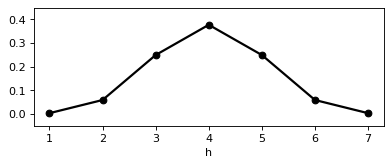

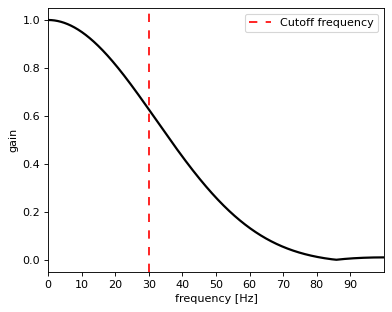

In [5]:
from scipy.signal import kaiserord, lfilter, firwin, freqz

nyq_rate = sampling_frequency / 2.0   # The Nyquist rate of the signal
width = 5.0/nyq_rate                  # The desired width of the transition from pass to stop
ripple_db = 10                        # The desired attenuation in the stop band, in dB
N, beta = kaiserord(ripple_db, width) # Compute the order and Kaiser parameter for the FIR filte

#FIR filter coefficients
#fig, (ax1, ax2) = plt.subplots(1,2, figsize = (15,5))
plt.figure(figsize=(5,2), dpi=80)
plt.plot(range(1,8,1),h, color = '0',marker='o', linewidth=2)
#plt.title('Filter Coefficients (%d h)' % N)
plt.tight_layout()
plt.ylim(-0.05, 0.45)
plt.xlabel('h')
plt.xticks(range(1,8,1))
plt.savefig('./img/filter_coefficients.pdf')

# Response of the filter
w, h1 = freqz(h, worN=8000)
plt.figure(figsize=(5,4), dpi=80)
plt.plot((w/np.pi)*nyq_rate, np.abs(h1), color= '0', linewidth=2 )
plt.xlabel('frequency [Hz]')
plt.ylabel('gain')
#plt.title('Frequency Response')
plt.ylim(-0.05, 1.05)
plt.xlim(0, 100)
plt.xticks(range(0,100,10))
plt.axline((cutoff_frequency, 0.5), (cutoff_frequency, 0.6), color="red", label = 'Cutoff frequency', linestyle=(0, (5, 5)))
plt.legend()
plt.tight_layout()
#plt.savefig('./img/filter_response.pdf')

## Sample waveform simulation

In this section we simulate different waveforms and add noise at higher frequencies. The template waveform will later be used to test the functionality of the FIR filter.

In [6]:
# some useful functions & definitions

def gen_time(lo,hi,freq): return np.linspace(lo,hi,(hi-lo)*freq)

def scaler(sig, waveform):
    print(len(waveform),'samples generated')
    print('The peak value is',  max(abs(waveform)) )
    fact = 100/max(abs(waveform)) # to keep the amplitude within the 8bit signed limits!
    print('I will scale the waveform of a factor', fact)
    sig = sig *fact
    waveform = waveform*fact
    return sig, waveform

def plot_waveform(x, sig, waveform, title=False):
    plt.figure( figsize=(8,4), dpi=80 )
    plt.plot( x, waveform, label='waveform', color = 'g', alpha = 0.7)
    plt.plot( x, sig, label='wave (noiseless)', color = 'k')
    plt.xlabel('time [s]'); plt.ylabel('strain');
    if title != False:
        plt.title(title)
    plt.legend(); plt.tight_layout(); plt.show();

# the samples are stored as a dictionary of dictionaries:
poll = {}
def add_to_poll(idd, sig, waveform):
    poll[idd] = { 'sig':sig, 'waveform':waveform}

### 1. sine noised waveform 

We simulate a sin wave of frequency below the threshold value of FIR and we add it to a sin wave of higher frequency.

200 samples generated
The peak value is 1.6896199606272444
I will scale the waveform of a factor 59.18490686087574


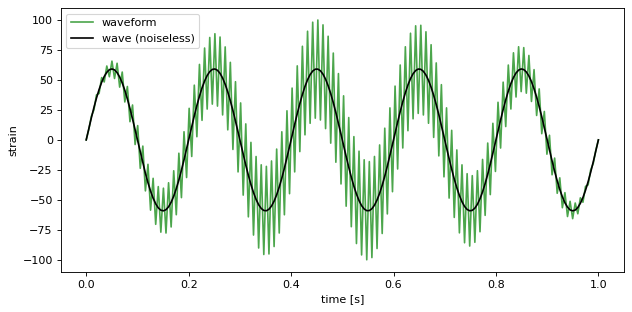

In [7]:
def sinn(x,freq): return np.sin(2*np.pi*freq*x)

x = gen_time(0,1,sampling_frequency)
sig = sinn(x,5)
waveform = sig + 0.7*sinn(x,100) #+ 0.5*sinn(x,54)
#                    100 Hz noise    54 Hz noise

sig, waveform = scaler( sig, waveform)
add_to_poll('sine', sig, waveform)

plot_waveform(x, sig, waveform)

In [8]:
# run this to save the waveform (or use the section at the bottom of the notebook)
#waveform = np.pad(waveform, (0, taps), 'constant')   # apply a padding
#np.savetxt(fname="sample_waveform.txt", X=waveform.astype(int), fmt ='%.0f')

### 2. gaussian noised wave

We simulate a gaussian wave and add random gaussian noise.

200 samples generated
The peak value is 1.5339647385328767
I will scale the waveform of a factor 65.1905467498833


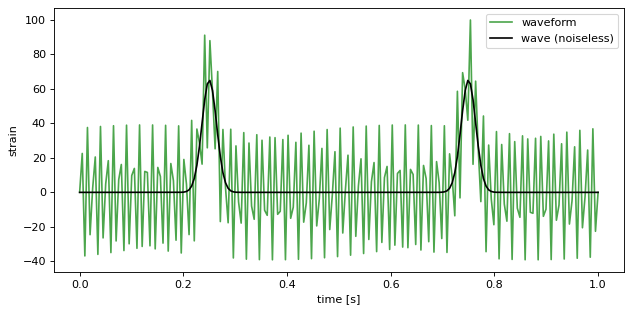

In [9]:
def gaus(x, center, sigma): return np.exp( -((x-center)/(2*sigma))**2 )

x = gen_time(0,1,sampling_frequency)
sig = gaus(x, 0.25, 0.01) + gaus(x, 0.75, 0.01)
#waveform = sig + 0.2*np.random.normal(0,1,len(sig))   # gaussian noise
waveform = sig + 0.6*sinn(x,80)                       # 80Hz noise

sig, waveform = scaler(sig, waveform)
add_to_poll('gaussian', sig, waveform)

plot_waveform(x, sig, waveform)

In [10]:
# run this to save the waveform (or use the section at the bottom of the notebook)
#waveform = np.pad(waveform, (0, taps), 'constant')   # apply a padding
#np.savetxt(fname="sample_waveform.txt", X=waveform.astype(int), fmt ='%.0f')

### 3. noised electrocardiogram

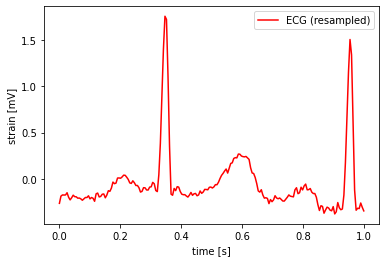

In [11]:
# import electrocardiogram from scipy archivef = signal.resample(y, 100)
from scipy.misc import electrocardiogram
ecg = electrocardiogram()
ecg_freq = 360
time_data = np.arange(ecg.size) / ecg_freq

# select fraction of signal (1 second)
sig = ecg[0:360]
#resampling
x, sig = gen_time(0,1,sampling_frequency), signal.resample(sig, sampling_frequency)

# plot
plt.plot(x,sig,label='ECG (resampled)', color='r')
plt.xlabel("time [s]")
plt.ylabel("strain [mV]")
plt.legend()
plt.show()

200 samples generated
The peak value is 1.9805472457536109
I will scale the waveform of a factor 50.491095435569555


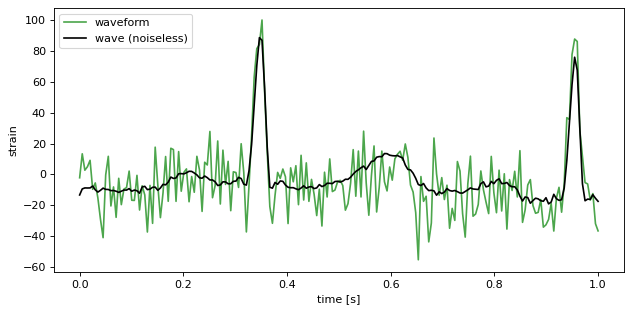

In [12]:
waveform = sig + 0.3*np.random.normal(0,1,len(sig))

sig, waveform = scaler(sig, waveform)
add_to_poll('ecg', sig, waveform)

plot_waveform(x, sig, waveform)

In [13]:
# run this to save the waveform (or use the section at the bottom of the notebook)
#waveform = np.pad(waveform, (0, taps), 'constant')   # apply a padding
#np.savetxt(fname="sample_waveform.txt", X=waveform.astype(int), fmt ='%.0f')

### save the template to file

This section saves the *selected* template waveform in a file, as a series of integer signed values. The file will be used to feed the FPGA or its simulation.

In [14]:
print('available samples in memory:', list(poll.keys()))
####################################################
selection = 'sine'   # defaults: sine, gaussian, ecg
####################################################

available samples in memory: ['sine', 'gaussian', 'ecg']


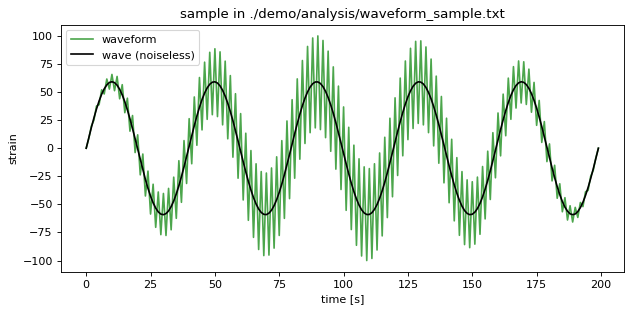

> saved ' sine ' to ./demo/analysis/waveform_sample.txt


In [15]:
waveform, sig = poll[selection]['waveform'], poll[selection]['sig']

plot_waveform( np.arange(len(waveform)), sig, waveform, title=f'sample in {template_waveform_file}')

waveform = np.pad(waveform, (0, taps), 'constant')     # apply a padding
np.savetxt(fname=template_waveform_file, X=waveform.astype(int), fmt ='%.0f')

print('> saved \'', selection, '\' to', template_waveform_file)

## **result visualization**

Note: run this section **after the signal processing** (simulation in vivado and/or real fpga).

Note 2: if the waveform noise has been computed through random values, python & fpga fir outputs will not match, of course...

### 1. simulation in Vivado

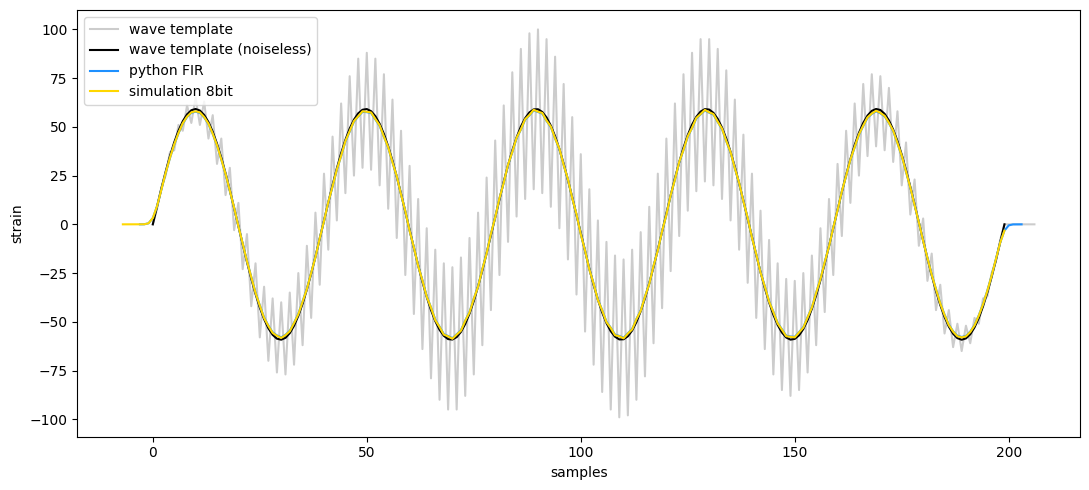

In [16]:
template_file = template_waveform_file
wf_template = np.loadtxt(template_file)    #  use   = waveform   to use the memorized object

if plot_simulations:
    try:
        sim_waveform = np.loadtxt(simulation_file)
        sim_waveform = sim_waveform/(2**bit_scaling)   # bit shift the full-bit simulation waveform
        sim8_waveform = np.loadtxt(simulation_file_8bit)
    except:
        print("WARNING: No simulation files. Skip the simulation plot!")
        plot_simulations = False


# python simulated FIR filter of coefficients h
py_fir_waveform = signal.lfilter(h, 1.0, wf_template)
delay = int( .5*taps )  # set phase delay of the filtered signal * sample_rate

# plot
plt.figure( figsize=(11,5), dpi=100 )

# waveform from template file
plt.plot( np.arange(len(wf_template)), wf_template, alpha=0.2, label='wave template', color='k')

# waveform (noiseless) from memory (look at selection!)
plt.plot( np.arange(len(sig)), sig, label='wave template (noiseless)', color='black')  

# python fir
plt.plot( np.arange(len(py_fir_waveform))-delay, py_fir_waveform, label='python FIR', color='dodgerblue')

# simulations
if plot_simulations:
    #plt.plot( np.arange(len(sim_waveform))-delay-delay_fpga_processing, sim_waveform, 
    #       label='simulation', color='orangered')
    plt.plot( np.arange(len(sim8_waveform))-delay-delay_fpga_processing, sim_waveform,
           label='simulation 8bit', color='gold')

plt.xlabel('samples'); plt.ylabel('strain');
plt.legend(); plt.tight_layout(); plt.show();

### simulation + fpga

In [17]:
!./tools/send_data_fpga.py -i $template_waveform_file -o $fpga_waveform

 >> using interface /dev/ttyUSB1
 === ./demo/analysis/waveform_sample.txt  -> FPGA ->  ./demo/analysis/fpga_sampling.txt ===
 > read values from file ./demo/analysis/waveform_sample.txt
 > 207 values acquired
 << serial >>
.
.
.
.
.
.
.
.
.
.
.
>> end of buffer


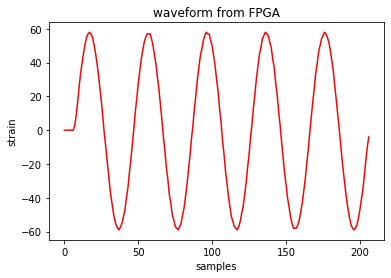

In [18]:
fpga_wave = np.loadtxt(fpga_waveform)
fpga_wave = fpga_wave * (2**(fpga_scaling-bit_scaling))

plt.plot( np.arange(len(fpga_wave)), fpga_wave, label='FPGA real', color='r') # real FPGA
plt.xlabel('samples'); plt.ylabel('strain'); plt.title('waveform from FPGA');
plt.show()

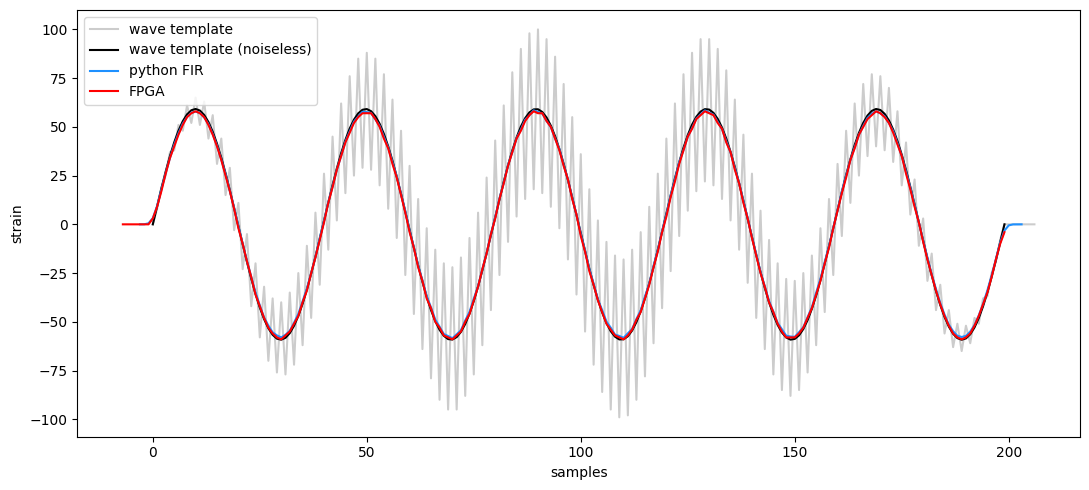

In [19]:
template_file = template_waveform_file
wf_template = np.loadtxt(template_file)

plot_simulations = False

if plot_simulations:
    try:
        sim_waveform = np.loadtxt(simulation_file)
        sim_waveform = sim_waveform/(2**bit_scaling)   # bit shift the full-bit simulation waveform
        sim8_waveform = np.loadtxt(simulation_file_8bit)
    except:
        print("WARNING: No simulation files. Skip the simulation plot!")
        plot_simulations = False

# python simulated FIR filter of coefficients h
py_fir_waveform = signal.lfilter(h, 1.0, wf_template)
delay = int( .5*taps )  # set phase delay of the filtered signal * sample_rate

# plot
plt.figure( figsize=(11,5), dpi=100 )

# waveform from template file
plt.plot( np.arange(len(wf_template)), wf_template, alpha=0.2, label='wave template', color='k')

# waveform (noiseless) from memory (look at selection!)
plt.plot( np.arange(len(sig)), sig, label='wave template (noiseless)', color='black')  

# python fir
plt.plot( np.arange(len(py_fir_waveform))-delay, py_fir_waveform, label='python FIR', color='dodgerblue')

# simulations
if plot_simulations:
    #plt.plot( np.arange(len(sim_waveform))-delay-delay_fpga_processing, sim_waveform, 
    #       label='simulation', color='orangered')
    plt.plot( np.arange(len(sim8_waveform))-delay-delay_fpga_processing, sim_waveform,
           label='simulation 8bit', color='gold')

# real FPGA
plt.plot( np.arange(len(fpga_wave))-delay_fpga_processing-delay, fpga_wave, label='FPGA', color='r')

plt.xlabel('samples'); plt.ylabel('strain');
plt.legend(); plt.tight_layout(); plt.show();

**observation**: The curves of python FIR and FPGA should overlap, so you will only see the FPGA curve (red).

#### **bibliography**

Python FIR filter: https://scipy-cookbook.readthedocs.io/items/FIRFilter.html

Firwin: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.firwin.html

**useful things**:

to check hex/bin values: https://www.rapidtables.com/convert/number/hex-to-decimal.html

End of file.